In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2
import sys; sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
from vocab import Vocab
voc = Vocab.from_file("../data/2.voc")

In [3]:
import tensorflow as tf
import models.transformer as tr
from lib.tensor_utils import infer_length, infer_mask

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction=0.333

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

mini_hp = {
        "hid_size": 256,
        "ff_size": 1024,
        "num_heads": 4,
        "num_layers": 4,
        "rescale_emb": True,
        "relu_dropout": 0.0,
        "res_dropout": 0.0,
        "attn_dropout": 0.0,
        "inp_emb_bias": True,
        "res_steps": "nlda",
        "normalize_out": True,
        "force_bos": True
}




In [4]:
from lib.transformer_layers import TransformerEncoder
from lib.layers import Dense
from lib.tensor_utils import infer_mask, infer_length

class TransformerLM:
    
    def __init__(self, name, voc, **hp):
        self.voc = voc
        self.name= name
        assert hp['force_bos'] is True, "this is build with force_bos in mind"
        hp['num_layers_enc'] = hp.get('num_layers', 1)
        
        with tf.variable_scope(name):
            self.enc = TransformerEncoder('main', 
                                          inp_voc=voc,
                                          allow_lookahead=False,
                                          **hp)
            self.logits = Dense('logits', self.enc.hid_size, len(voc))
            
    def __call__(self, inp, is_train=False, after_eos=False):
        mask = infer_mask(inp, self.voc.eos, dtype=tf.float32)
        inp_len = infer_length(inp, self.voc.eos)
        
        enc_out, _ = self.enc(inp, is_train=is_train)
        
        logits = self.logits(enc_out)
        
        # shift logits forward
        if not after_eos:
            logits = logits[:,:-1]
            
        logits = tf.concat([tf.one_hot(inp[:, :1], len(self.voc)) * 100, logits], axis=1)
        return logits
    


In [5]:
lines = open("../data/bpe_corpus2.txt").read().split('\n')[:-1]

In [6]:
_dummy = np.arange(5,30, dtype='int32').reshape([5,5])
inp = tf.placeholder_with_default(_dummy, [None,None])

In [7]:
lm = TransformerLM('lm', voc, **mini_hp)

In [8]:
logits = lm(inp, is_train=True)

In [9]:
from lib.tensor_utils import infer_mask, initialize_uninitialized_variables

nll = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=inp)

loss = nll * infer_mask(inp, voc.eos, dtype=tf.float32)

loss = tf.reduce_sum(loss, axis=1)
loss = tf.reduce_mean(loss)

In [10]:
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, lm.name)
grads = tf.gradients(loss, weights)
grads = tf.clip_by_global_norm(grads, 100)[0]
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, beta2=0.98).apply_gradients(zip(grads,weights))

In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
initialize_uninitialized_variables(sess)

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
from pandas import ewma
from tqdm import tqdm
from time import sleep
epoch = 0
loss_history = []

In [14]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        


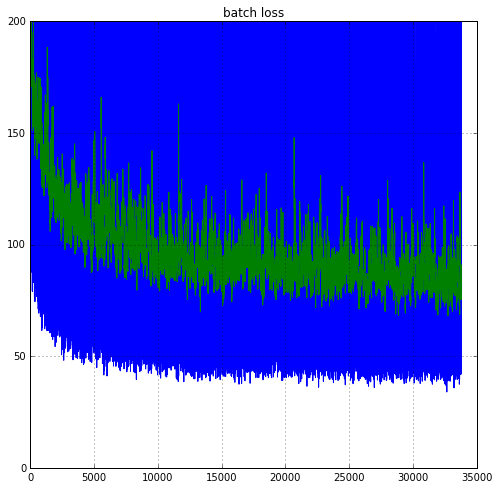

  8%|▊         | 2576/31250 [05:22<59:54,  7.98it/s]

KeyboardInterrupt: 

In [16]:
from random import shuffle
batch_size = 32
num_epochs = 2
max_len = 200

for epoch in range(num_epochs):
    print("Beginning epoch", epoch)
    order = {line: len(line) * (1 + np.random.normal(0, 0.2)) for line in lines}
    lines = sorted(lines, key = lambda line: order[line])
    lines = np.array(lines)
    batches = list(chunks(lines, batch_size))
    shuffle(batches)

    for batch in tqdm(batches):

        # Note: we don't use voc.tokenize_many(batch, max_len=max_len)
        # cuz it forces batch length to be that long and we often get away with much less
        batch_ix = voc.tokenize_many(batch)[:, :max_len]

        feed_dict = {inp: batch_ix}

        loss_t = sess.run([train_step, loss], feed_dict)[1]
        loss_history.append(np.mean(loss_t))


        if (epoch+1) % 500 == 0:
            w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=lm.name)
            w_values = sess.run(w_variables)
            weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
            np.savez("../../pretrained_lm_lang1-%i.npz"%epoch, **weights_dict)


        if epoch % 10 == 0:
            clear_output(True)
            plt.figure(figsize=[8,8])
            plt.title("batch loss")
            plt.plot(loss_history)
            plt.plot(ewma(np.array(loss_history),span=50))
            plt.ylim(0,200)
            plt.grid()
            plt.show()
        epoch +=1


In [ ]:
raise 1

In [ ]:
def sample(max_len):
    seq = np.array([[0, np.random.randint(3, len(voc))]])
    logits = lm(inp, is_train=False, after_eos=True)
    
    for i in range(10):
        feed_dict = {inp : seq}
        #print(tf.nn.softmax(logits).eval(feed_dict)[0][-1])
        el = np.random.choice(range(len(voc)), p =  tf.nn.softmax(logits * 10).eval(feed_dict)[0][-1])
        #print(el)
        seq = np.concatenate((seq, np.array([[el]])), 1)
    return seq[0]

In [ ]:
for i in range(20):
    print(voc.detokenize(sample(15)))

In [ ]:
w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=lm.name)
w_values = sess.run(w_variables)
weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
np.savez("../pretrained/lm_default_params-final_1.npz", **weights_dict)